# Taxonomy Completion with Embedding Quantization and an LLM-based Pipeline: A Case Study in Computational Linguistics

The ever-growing volume of research publications demands efficient methods for structuring academic knowledge. This task typically involves developing a supervised underlying scheme of classes and allocating publications to the most relevant class. In this article, we implement an end-to-end automated solution leveraging open-source embedding quantization and a Large Language Model (LLM) pipeline. Our playground is a dataset of [25,000 arXiv publications](https://huggingface.co/datasets/dcarpintero/arxiv.cs.CL.25k) from Computational Linguistics (cs.CL), published before July 2024, which we aim to organize under a novel candidate scheme of cs.CL sub-classes.

## Methodology

Our approach centers on two key tasks: (i) unsupervised clustering of the arXiv dataset into related collections, and (ii) discovering the latent thematic structures within each cluster.

At its core, the clustering task requires identifying a sufficient number of similar examples within our *unlabeled* dataset.
This is a natural task for embeddings, as they capture semantic relationships in a corpus and can be provided as input features to a clustering algorithm to establish similarity links among examples. We begin by transforming the (*title*:*abstract*) pairs of the dataset into an embeddings representation using [Jina-Embeddings-v2](https://arxiv.org/abs/2310.19923), a BERT-ALiBi based attention model supporting 8192 sequence lengths. We then apply scalar quantization with [Sentence Transformers](https://www.sbert.net/). And run [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html) in a reduced dimensional space to perform the clustering.

To discover the latent topics within each cluster of arXiv publications, we combine [LangChain](https://www.langchain.com/) and [Pydantic](https://docs.pydantic.dev/) with [Mistral-7B-Instruct-v0.3](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.3) into an LLM-pipeline that provides structured output.

The results hint at emerging research domains around Language Models (LLMs) in the field of Computational Linguistics (cs.CL). This approach might serve as a baseline for automatically identifying candidate (sub)classes within high-level [arXiv categories](https://arxiv.org/category_taxonomy) and efficiently completing taxonomies, addressing the challenge posed by the increasing volume of academic literature.

<p align="center">
  <img style="margin: 0 auto; display: block;" src="https://cdn-uploads.huggingface.co/production/uploads/64a13b68b14ab77f9e3eb061/Ghc69tCVsY-RMXD50PeIC.png">
</p>
<p align="center">Taxonomy Completion of Academic Literature with Embedding Quantization and an LLM-Pipeline</p>

In [33]:
%pip install altair datasets hdbscan umap-learn sentence-transformers --quiet

## 1. Embedding Transformation

Embeddings are numerical representations of real-world objects like text, images, and audio that encapsulate semantic information of the data they represent. They are used by AI models to understand complex knowledge domains in downstream applications such as clustering, as well as information retrieval and classification tasks, among others.

#### Supporting Large Sequences

We will map (*title*:*abstract*) pairs from arXiv publications to a 768 dimensional space using [Jina-Embeddings-v2](https://arxiv.org/abs/2310.19923) [1], an open-source text embedding model capable of accommodating up to 8192 tokens. This provides a sufficiently large sequence length for titles, abstracts, and other document sections that might be relevant. To overcome the conventional 512-token limit  present in other models, Jina-Embeddings-v2 incorporates bidirectional [ALiBi](https://arxiv.org/abs/2108.12409) [2] into the BERT framework. ALiBi (Attention with Linear Biases) enables input length extrapolation (i.e. sequences exceeding 2048 tokens) by encoding positional information directly within the self-attention layer, instead of introducing positional embeddings. In practice, it biases query-key attention scores with a penalty that is proportional to their distance, favoring stronger mutual attention between proximate tokens.

#### Encoding with Sentence Transformers

The first step to use the [Jina-Embeddings-v2](https://huggingface.co/jinaai/jina-embeddings-v2-base-en) model is to load it through [Sentence Transformers](https://www.SBERT.net), a framework for accessing state-of-the-art models that is available at the [Hugging Face Hub](https://huggingface.co/models?library=sentence-transformers&sort=downloads). There you can find over 500 hundreds models such as [all-MiniLM-L12-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L12-v2) and [all-mpnet-base-v2](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) that are also suitable for text encoding.

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('jinaai/jina-embeddings-v2-base-en', trust_remote_code=True)

We now encode (*title*:*abstract*) pairs of our dataset using `batch_size = 64`. This allows for parallel computation on hardware accelerators like GPUs (albeit at the cost of requiring more memory).

In [49]:
from datasets import load_dataset

ds = load_dataset("dcarpintero/arxiv.cs.CL.25k", split="train")
ds

Dataset({
    features: ['publication_date', 'doc_url', 'id', 'authors', 'update_date', 'category_all', 'abstract', 'category_primary', 'title'],
    num_rows: 25107
})

The encoding process might take a few minutes. As an alternative you might skip this step, and load the prepared dataset with embeddings.

In [65]:
corpus = [title + ': ' + abstract for title, abstract in zip(ds['title'], ds['abstract'])]
f32_embeddings = model.encode(corpus,
                              batch_size=64,
                              show_progress_bar=True)

Batches:   0%|          | 0/393 [00:00<?, ?it/s]

In [ ]:
# load processed float32 embeddings from the Hugging Face Hub

#from datasets import load_dataset
#ds = load_dataset("dcarpintero/arxiv.cs.CL.25k.embeddings.jina", split="train")
#f32_embeddings = ds['embeddings']

## 2. Embedding Quantization for Memory Saving

Scaling up embeddings can be challenging. Currently, state-of-the-art models represent each embedding as `float32`, which requires 4 bytes of memory. Given that Jina-Embeddings-v2 maps text to a 768 dimensional space, the memory requirements for our dataset would be around 73 MB without index and other metadata:

```python
25,000 embeddings * 768 dimensions/embedding * 4 bytes/dimension = 76,800,000 bytes
76,800,000 bytes / (1024^2) ≈ 73.24 MB
```

However, if you work with a larger dataset, the memory requirements and associated costs might increase significantly:

| Embedding<br>Dimension | Embedding<br>Model            | 2.5M<br>ArXiv Abstracts      | 60.9M<br>Wikipedia Docs | 100M<br>Embeddings |
|------------------------|-------------------------------|------------------------------|-----------------------|------------------------------|
| 384                    | all-MiniLM-L12-v2             | 3.57 GB                      | 85.26 GB              | 142.88 GB                    |
| 768                    | all-mpnet-base-v2             | 7.15 GB                      | 170.52 GB             | 285.76 GB                    |
| 768                    | jina-embeddings-v2            | 7.15 GB                      | 170.52 GB             | 285.76 GB                    |
| 1536                   | openai-text-embedding-3-small | 14.31 GB                     | 341.04 GB             | 571.53 GB                    |
| 3072                   | openai-text-embedding-3-large | 28.61 GB                     | 682.08 GB             | 1.143 TB                   |


A technique used to achieve memory saving is *Quantization*. The intuition behind this approach is that we can discretize  floating-point values by mapping their range [`f_max`, `f_min`] into a smaller range of fixed-point numbers [`q_max`, `q_min`], and linearly mapping all values between these ranges. In practice, this typically reduces the precision of a 32-bit floating-point to lower bit widths like 8-bits (scalar-quantization) or 1-bit values (binary quantization).

<p align="center">
  <img style="margin: 0 auto; display: block;" src="https://cdn-uploads.huggingface.co/production/uploads/64a13b68b14ab77f9e3eb061/9r3rD0Dk2H4FnvVOC3rro.png">
</p>
<p align="center">
Scalar Embedding Quantization - from <em>float32</em> to <em>(u)int8</em>
</p>

By plotting the frequency distribution of our embeddings, we observe that the values are indeed concentrated around a relatively narrow range [-2.0, +2.0]. This means we can effectively map the `float32` values to 256 `(u)int8` buckets without significant loss of information:

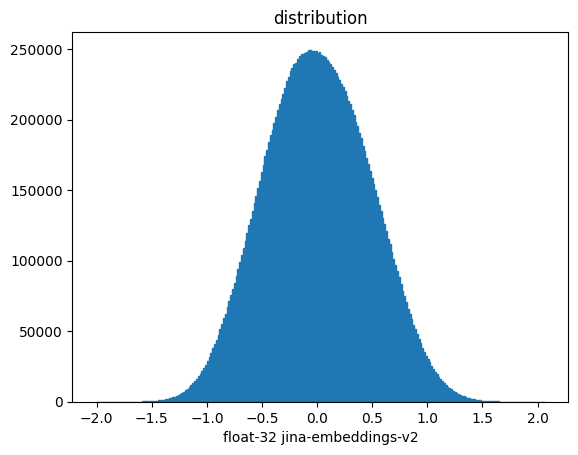

In [66]:
import matplotlib.pyplot as plt

# histogram - embeddings distribution
plt.hist(f32_embeddings.flatten(), bins=250, edgecolor='C0')
plt.xlabel('float-32 jina-embeddings-v2')
plt.title('distribution')
plt.show()

We can calculate the exact `[min, max]` values of the distribution:

In [67]:
np.min(f32_embeddings), np.max(f32_embeddings)

(-2.0162134, 2.0746827)

A calibration set of 10k embeddings covers, in our case, nearly 99.99% of the original `float32` values. This calibration practice intents to obtain representative `f_min` and `f_max` values without the computational overhead and potential issues caused by outliers that might appear in larger datasets.

In [68]:
import numpy as np

calibration_embeddings = f32_embeddings[:10000]
f_min = np.min(calibration_embeddings)
f_max = np.max(calibration_embeddings)

# calculate percentage in range
f32_values_in_range = np.sum((f32_embeddings >= f_min) & (f32_embeddings <= f_max))
percentage_in_range = (f32_values_in_range / f32_embeddings.size) * 100

print(f"[f_min, f_max] calibration embeddings: [{f_min, f_max}]")
print(f"Percentage of embeddings within [f_min, f_max]: {percentage_in_range:.5f}%")

[f_min, f_max] calibration embeddings: [(-2.0162134, 2.0746827)]
Percentage of embeddings within [f_min, f_max]: 100.00000%


This scalar quantization approach can be easily applied with [Sentence Transformers](https://www.sbert.net/), resulting in a 4x memory saving compared to the original float32 representation. Moreover, we will also benefit from faster arithmetic operations since matrix multiplication can be performed faster with integer arithmetic.

In [69]:
import numpy as np
from sentence_transformers.quantization import quantize_embeddings

# quantization is applied in a post-processing step
int8_embeddings = quantize_embeddings(
    np.array(f32_embeddings),
    precision="uint8",
    calibration_embeddings=np.array(f32_embeddings[:20000]),
)

In [70]:
f32_embeddings.dtype, f32_embeddings.shape, f32_embeddings.nbytes, (np.max(f32_embeddings), np.min(f32_embeddings))

(dtype('float32'), (25107, 768), 77128704, (2.0746827, -2.0162134))

In [71]:
int8_embeddings.dtype, int8_embeddings.shape, int8_embeddings.nbytes, (np.max(int8_embeddings), np.min(int8_embeddings))

(dtype('uint8'), (25107, 768), 19282176, (255, 0))

We choose to continue with quantized embeddings:

In [79]:
# switch to `f32_embeddings` if you prefer to not use quantization
embeddings = int8_embeddings

## 3. Projecting Embeddings for Dimensionality Reduction

In this section, we perform a two-stage projection of (title:abstract) embedding pairs from their original high-dimensional space (768) to lower dimensions, namely:
- `5 dimensions` for reducing computational complexity during clustering, and
- `2 dimensions` for enabling visual representation in `x, y` coordinates.

For both projections, we employ [UMAP](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction#Uniform_manifold_approximation_and_projection), a popular dimensionality reduction technique known for its effectiveness in preserving both the local and global data structures. In practice, this makes it a preferred choice for handling complex datasets with high-dimensional embeddings.

In [81]:
import umap

embedding_5d = umap.UMAP(n_neighbors=100,
                         n_components=5,
                         min_dist=0.1,
                         metric='cosine').fit_transform(embeddings)

embedding_2d = umap.UMAP(n_neighbors=100,
                         n_components=2,
                         min_dist=0.1,
                         metric='cosine').fit_transform(embeddings)

In our implementation, we configure UMAP with:
- `n_neighbors=100` to consider 100 nearest neighbors for each point (arXiv publication);
- `n_components=5` to reduce the embeddings from 768 to 5 (or 2) dimensions;
- `min_dist=0.1` to maintain a balance between the local and global structure; and,
- `metric='cosine'` to measure the distance between points using the cosine similarity metric.

Note that when we apply HDBSCAN clustering in the next step, the clusters found will be influenced by how UMAP preserved the local structures. A smaller `n_neighbors` value means UMAP will focus more on local structures, whereas a larger value allows to capture more global representations, which might be beneficial for understanding overall patterns in the data.

## 4. Semantic Clustering

The reduced (*title*:*abstract*) embeddings can be used as input features of a clustering algorithm, enabling the identification of related categories based on embedding distances.

We have opted for [HDBSCAN](https://en.wikipedia.org/wiki/HDBSCAN) (Hierarchical Density-Based Spatial Clustering of Applications with Noise) [4], an advanced clustering algorithm that extends DBSCAN by adapting to varying density clusters. Unlike K-Means which requires pre-specifying the number of clusters, HDBSCAN has only one important hyperparameter, `n`, which establishes the minimum number of examples to include in a cluster.

HDBSCAN works by first transforming the data space according to the density of the data points, making denser regions (areas where data points are close together in high numbers) more attractive for cluster formation. The algorithm then builds a hierarchy of clusters based on the minimum cluster size established by the hyperparameter `n`. This allows it to distinguish between noise (sparse areas) and dense regions (potential clusters). Finally, HDBSCAN condenses this hierarchy to derive the most persistent clusters, efficiently identifying clusters of different densities and shapes. As a density-based method, it can also detect outliers in the data.

In [82]:
import hdbscan

hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=100,
                                metric='euclidean',
                                cluster_selection_method='leaf')
clusters = hdbscan_model.fit_predict(embedding_5d)

The `cluster_selection_method` determines how HDBSCAN selects flat clusters from the tree hierarchy. Using `eom` (Excess of Mass) cluster selection method in combination with embedding quantization, tended to create a few larger, less specific clusters. These clusters would have required a further *reclustering process* to extract meaningful latent topics. Instead, by switching to the `leaf` selection method, the algorithm selects leaf nodes from the cluster hierarchy, and produced a more fine grained clustering compared to the Excess of Mass method.

We map now each cluster to the arXiv records in a dataframe:

In [83]:
#import pandas as pd

#df = pd.DataFrame(embedding_2d, columns=['x', 'y'])
#df['cluster'] = clusters
#df['title'] = ds_fp32['title']

#df = df[df['cluster'] != -1] # remove outliers

In [42]:
import pandas as pd

df = ds.to_pandas()
df['x'] = embedding_2d[:, 0]
df['y'] = embedding_2d[:, 1]
df['cluster'] = clusters
df = df[df['cluster'] != -1] # remove outliers

In [84]:
df[['x', 'y', 'cluster', 'title']].head(5)

,x,y,cluster,title
1,8.239624,7.725149,19,InternLM-XComposer-2.5: A Versatile Large Visi...
2,5.289915,1.329878,2,BACON: Supercharge Your VLM with Bag-of-Concep...
4,5.182182,1.482455,2,LLM Internal States Reveal Hallucination Risk ...
5,9.689983,5.094613,23,Evaluating Automatic Metrics with Incremental ...
6,3.476390,5.813745,24,How Similar Are Elected Politicians and Their ...


## 5. Uncovering Latent Topics with an LLM-Pipeline

Having performed the clustering step, we now illustrate how to identify the topic of each cluster by combining an LLM such as [Mistral-7B-Instruct](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.3) with [Pydantic](https://docs.pydantic.dev/) and [LangChain](https://www.langchain.com/) to create a topic modeling pipeline.

In [21]:
%pip install huggingface_hub langchain langchain_huggingface --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.6/983.6 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.9/357.9 kB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 22.6 MB/s eta 0:00:00


### 4.1 Pydantic Model

[Pydantic Models](https://docs.pydantic.dev/latest/concepts/models/) are classes that derive from `pydantic.BaseModel`, defining fields as type-annotated attributes. They are similar to `Python` dataclasses. However, they have been designed with subtle but significant differences that optimize various operations such as validation, serialization, and `JSON` schema generation. Our `Topic` class defines a field named `label`. This will generate output in a structured format, rather than a free-form text block, facilitating easier processing and analysis of the inference results.

In [22]:
from pydantic import BaseModel, Field

class Topic(BaseModel):
    """
    Pydantic Model to generate an structured Topic Model
    """
    label: str = Field(..., description="Identified topic")

### 4.2 LangChain Prompt Template

[LangChain Prompt Templates](https://python.langchain.com/v0.2/docs/concepts/#prompt-templates) are pre-defined recipes for translating user input and parameters into instructions for a language model.

In [23]:
from langchain_core.prompts import PromptTemplate

topic_prompt = """
    You are a helpful Research Engineer. Your task is to analyze a set of research paper titles related to Natural Language Processing and
    determine the overarching topic of the cluster. Based on the titles provided, you should identify and label the most relevant topic.
    The response should be concise, clearly stating the single  identified topic. Format your response in JSON as indicated in the 'EXPECTED OUTPUT' section below.
    No additional information or follow-up questions are needed.

    EXPECTED OUTPUT:
    {{"label": "Topic Name"}}

    TITLES:
    {titles}
    """

### 4.3 Inference of Topic Identification

This section illustrates how to compose a topic pipeline using the [LangChain Expression Language (LCEL)](https://python.langchain.com/v0.2/docs/concepts/#langchain-expression-language-lcel).

In [24]:
import os
from google.colab import userdata
os.environ["HUGGINGFACEHUB_API_TOKEN"] = userdata.get('HUGGINGFACEHUB_API_TOKEN')

In [25]:
import os

from langchain.chains import LLMChain
from langchain_huggingface import HuggingFaceEndpoint
from langchain_core.output_parsers import PydanticOutputParser

from typing import List

def TopicModeling(titles: List[str]) -> str:
    """
    Infer the common topic of the given titles w/ LangChain, Pydantic, Mistral-7B-Instruct
    """
    repo_id = "mistralai/Mistral-7B-Instruct-v0.3"
    llm = HuggingFaceEndpoint(
        repo_id=repo_id,
        temperature=0.2,
        huggingfacehub_api_token=os.environ["HUGGINGFACEHUB_API_TOKEN"]
    )
    prompt = PromptTemplate.from_template(topic_prompt)
    parser = PydanticOutputParser(pydantic_object=Topic)

    topic_chain = prompt | llm | parser
    return topic_chain.invoke({"titles": titles})

To enable the model to infer the topic of each cluster, we provide a subset of 25 paper titles from each cluster as input.

In [26]:
%%capture
topics = []
for i, cluster in df.groupby('cluster'):
    titles = cluster['title'].head(25).tolist()
    topic = TopicModeling(titles)
    topics.append(topic.label)

Let's assign each arXiv publication to its corresponding cluster, and examine the topics inferred by the model.

In [27]:
n_clusters = len(df['cluster'].unique())

topic_map = dict(zip(range(n_clusters), topics))
df['topic'] = df['cluster'].map(topic_map)

In [28]:
df['topic'].value_counts()

topic
Speech Recognition and Translation                          1176
Natural Language Processing in Healthcare                   1084
Multimodal Language Models                                  1040
Multilingual Language Models and Machine Translation         800
Chain-of-Thought Reasoning in Language Models                511
Personalized Dialogue Systems                                503
Bias Mitigation in NLP Models                                427
Efficient Sparse Attention for Transformer Models            426
Knowledge Graph Question Answering                           364
Preference Learning for Large Language Models                303
Emotion Recognition in Conversations                         303
Language Model-based Autonomous Agents and Planning          269
Hate Speech Detection                                        258
Prompt Optimization                                          245
Hallucination in Language Models                             243
Fake News Detection

## 6. Results

### 6.1 Analyzing the effects of Quantization on Clustering

In [30]:
%pip install vegafusion[embed]>=1.5.0

In [31]:
import altair as alt
alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

In [32]:
custom_color_palette = [
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
    '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
    '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
    '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5',
    '#393b79', '#5254a3', '#6b6ecf', '#9c9ede', '#637939',
    '#8ca252', '#b5cf6b', '#cedb9c', '#8c6d31', '#bd9e39',
    '#e7ba52', '#e7cb94', '#843c39', '#ad494a', '#d6616b'
]

chart = alt.Chart(df).mark_circle(size=5).encode(
    x='x',
    y='y',
    color=alt.Color('topic:N', scale=alt.Scale(range=custom_color_palette)),
    tooltip=['title', 'topic']
).interactive().properties(
    title='25K arXiv Publications in cs.CL',
    width=600,
    height=400,
)
chart.display()

alt.Chart(...)

### 6.2 Candidate Taxonomy

[...]

----